## Логистическая регрессия

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

В связи с тем, что при вычислении скалярного произведения w и x, могут получаться очень большие scores, то при расчете вероятности с помощи сигмоиды, значения будут получаться слишком близкими к 0 или 1.  
В результате чего, из-за ограничений точности float, в расчетах может возникнуть log0, или ошибки в арифметических операциях (переполнение и т.д.). 
  
Данную проблему частично удалось решить следующими способами:
- Ограничение значения score при его расчете в диапазоне [-10, 10] (с помощью функции np.clip())  
- Нормализация данных перед обучением модели

Однако, если указать экстремальные значения alpha и C, ошибки в арифметических операциях все равно могут присутствовать.

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, penalty='l2', random_seed=42):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        penalty - тип регуляризации ('l1' - LASSO, 'l2' - Ridge, 'no'- без регуляризации)
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.penalty = penalty
        
        # Добавлена возможность сохранения seed для генерации начальных значений theta
        self.random_seed = random_seed
    
    
    @staticmethod
    def _calculate_reg_cost(penalty, m, C, theta):
        """Расчет слагаемого регуляризации для подсчета функции эмпирического риска
        
        penalty - тип регуляризации
        m - кол-во объектов в тренировочных данных
        C - коэффициент, обратный коэффициенту регуляризации
        theta - вектор весов
        """
        
        if penalty == 'l2':
            reg_cost = (1 / (2 * C * m)) * np.sum(theta**2)
        elif penalty == 'l1':
            reg_cost = (1 / (C * m)) * np.sum(np.abs(theta))
        elif penalty == 'no':
            reg_cost = 0

        return reg_cost
    
    
    @staticmethod
    def _calculate_reg_grad(penalty, m, C, theta):
        """Расчет градиента слагаемого регуляризации для подсчета общего значения градиента
        
        penalty - тип регуляризации
        m - кол-во объектов в тренировочных данных
        C - коэффициент, обратный коэффициенту регуляризации
        theta - вектор весов
        """
        if penalty == 'l2':
            reg_grad = (1 / C) * theta    
        elif penalty == 'l1':
            # Т.к. модуль не дифференцируем в точке 0, 
            # в качестве производной используется знак значения параметра
            reg_grad = (1 / C) * np.sign(theta)
        elif penalty == 'no':
            reg_grad = 0
        
        return reg_grad

    
    def fit(self, X, y):
        '''
        Обучение модели
        '''
        
        # Используются стандартные проверки и сохранение входных данных, взято из шаблона sklearn для
        # создания custom estimators
        # https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/template.py
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        
        # Сохранение кол-ва объектов/признаков в тренировочном датасете
        # и добавляем вектор единиц к датасету
        m, n = self.X_.shape 
        X_b = np.c_[np.ones(m), X]
        
        # Генерация начальных значений весов
        np.random.seed(self.random_seed)
        self.theta_ = np.random.randn(n+1, 1)
        
        self.costs_ = np.zeros(self.max_epoch)
        self.coefs_ = []
        
        for epoch in range(self.max_epoch):
            # Перемешивание данных
            shuffled_indices = np.random.permutation(m)
            
            errors = np.zeros(m)
            
            for (i, idx) in enumerate(shuffled_indices):
                # Выбор случайного объекта
                x_i = X_b[idx:idx+1]
                y_i = y[idx:idx+1]
                
                # Ограничение score для снижения вероятности переполнения в арифметических операциях
                score = np.clip(x_i.dot(self.theta_), -10, 10)
                
                # Расчет градиента (основной и регуляризационной частей)
                y_pred_proba = 1 / (1 + np.exp(-score))
                grad = x_i.T.dot(y_pred_proba - y_i)
                reg_grad = self._calculate_reg_grad(self.penalty, m, self.C, self.theta_[1:])
                
                # Обновление весов 
                self.theta_[0] = self.theta_[0] - self.alpha * grad[0] 
                self.theta_[1:] = self.theta_[1:] - self.alpha * (grad[1:] + reg_grad)
                
                # Расчет ошибки на данной итерации
                errors[i] = -(y_i*np.log(y_pred_proba) + (1 - y_i)*np.log(1 - y_pred_proba))
            
            # Расчет эмпирического риска
            reg_cost = self._calculate_reg_cost(self.penalty, m, self.C, self.theta_[1:])
            self.costs_[epoch] = 1/m * np.sum(errors) + reg_cost
            
            # Сохранение промежуточного значений весов для дальнейшей визуализации
            self.coefs_.append(self.theta_.copy())
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        # Не делал, т.к. решил побольше разобраться в основной части
        # В sklearn для SGDClassifier есть метод partial_fit(), который судя по описанию, используется для 
        # возможности использования Minibatch SGD, а также есть параметр warm_start, который похоже 
        # используется для возможности дообучения модели.
        # В описании тут указано, что partial_fit используется также для дообучения.
        # Расскажите, пожалуйста, если есть опыт в этом, как правильно использовать partial_fit с SGD, 
        # и в чем его отличие от warm_start
        
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        check_is_fitted(self, 'X_', 'y_')
        X = check_array(X)
        
        m = len(X)
        X_b = np.c_[np.ones(m), X]
        
        score = X_b.dot(self.theta_)
        y_pred_proba = 1 / (1 + np.exp(-score))
        
        y_hat = np.where(y_pred_proba >= 0.5, 1, 0)
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        check_is_fitted(self, 'X_', 'y_')
        X = check_array(X)
        
        # Сохранение кол-ва объектов в тренировочном датасете
        # и добавляем вектор единиц к датасету
        m = len(X)
        X_b = np.c_[np.ones(m), X] 
        
        # Расчет вероятности принадлежности объектов к классам 0 и 1
        score = X_b.dot(self.theta_)
        y_1 = 1 / (1 + np.exp(-score))
        y_0 = 1 - y_1
        y_hat_proba = np.c_[y_0, y_1]
        
        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

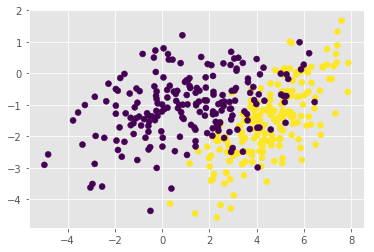

In [3]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [4]:
model = MySGDClassifier()
model.fit(X, y)

MySGDClassifier(C=1, alpha=0.01, max_epoch=10, penalty='l2', random_seed=42)

### Полученные веса модели

In [5]:
model.theta_

array([[-1.16632867],
       [ 0.31564555],
       [-0.08108881]])

### Построение разделяющей границы между классами

Построение выполнено на обученной модели выше, как было указано в задаче ДЗ:
- С параметрами по умолчанию, которые, судя по всему, не являются оптимальными
- Не проводилось нормирование данных до обучения модели 
  
В связи с этим, разделяющая граница, возможно выглядит не оптимальной

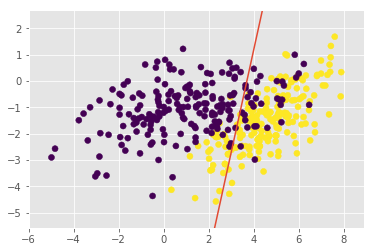

In [6]:
def plot_decision_boundary(model, X, y):
    fig, ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1], c=y)

    theta = model.theta_.ravel()
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    x_bound = np.array([x_min, x_max])
    y_bound = -(theta[0] + theta[1] * x_bound) / theta[2]

    ax.plot(x_bound, y_bound)
    ax.set_xlim(x_min - 1, x_max + 1)
    ax.set_ylim(y_min - 1, y_max + 1)
    plt.show()
    
plot_decision_boundary(model, X, y)

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from pandas import Series, DataFrame

Для дальнейшего анализа, проведем нормализацию данных

In [8]:
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X, y)

Создадим сетку основных параметров, по которым будем строить графики эмпирического риска после каждой эпохи

In [9]:
params = {'alpha': [0.0001, 0.001, 0.01, 1], 'max_epoch': [10, 100, 1000]}
param_grid = ParameterGrid(params)
list(param_grid)

[{'alpha': 0.0001, 'max_epoch': 10},
 {'alpha': 0.0001, 'max_epoch': 100},
 {'alpha': 0.0001, 'max_epoch': 1000},
 {'alpha': 0.001, 'max_epoch': 10},
 {'alpha': 0.001, 'max_epoch': 100},
 {'alpha': 0.001, 'max_epoch': 1000},
 {'alpha': 0.01, 'max_epoch': 10},
 {'alpha': 0.01, 'max_epoch': 100},
 {'alpha': 0.01, 'max_epoch': 1000},
 {'alpha': 1, 'max_epoch': 10},
 {'alpha': 1, 'max_epoch': 100},
 {'alpha': 1, 'max_epoch': 1000}]

In [10]:
def plot_cost(X, y, param_grid):
    max_epoch_list = sorted(set([param['max_epoch'] for param in param_grid]))
    max_epoch_count = len(max_epoch_list)
    fig, axes = plt.subplots(max_epoch_count, 1, squeeze=False, figsize=(10, 15))
    
    for i, max_epoch in enumerate(max_epoch_list):
        max_epoch_grid = [param for param in param_grid if param['max_epoch'] == max_epoch]
        
        for params in max_epoch_grid:
            model = MySGDClassifier()
            model.set_params(**params)
            model.fit(X, y)

            label = 'alpha: {}'.format(params['alpha'])
            title = 'max_epoch: {}, penalty: {}'.format(params['max_epoch'], params['penalty'])
            
            axes[i, 0].plot(model.costs_, label=label)
            axes[i, 0].set_title(title)
            axes[i, 0].legend(loc='upper left', bbox_to_anchor=(1.02, 1))
            axes[i, 0].set_xlabel('Number of epochs')
            axes[i, 0].set_ylabel('Cost')
            plt.tight_layout()
            
    plt.show()

Для анализа, помимо использования l1 и l2 регуляризаций, обучаю также и модели без регуляризации

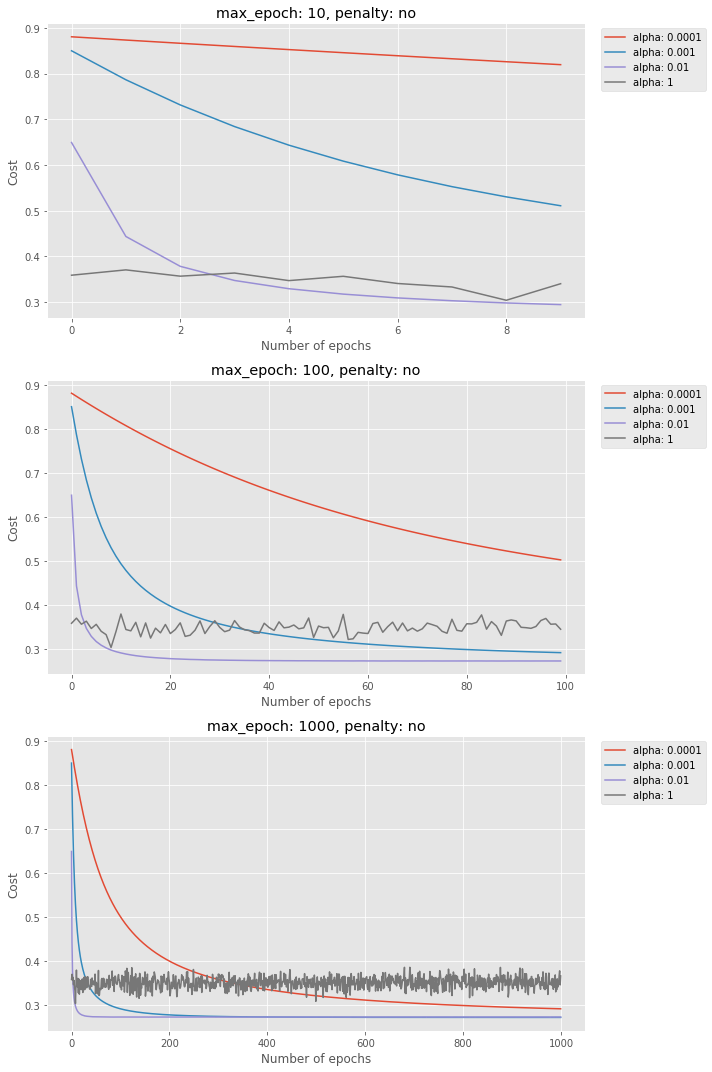

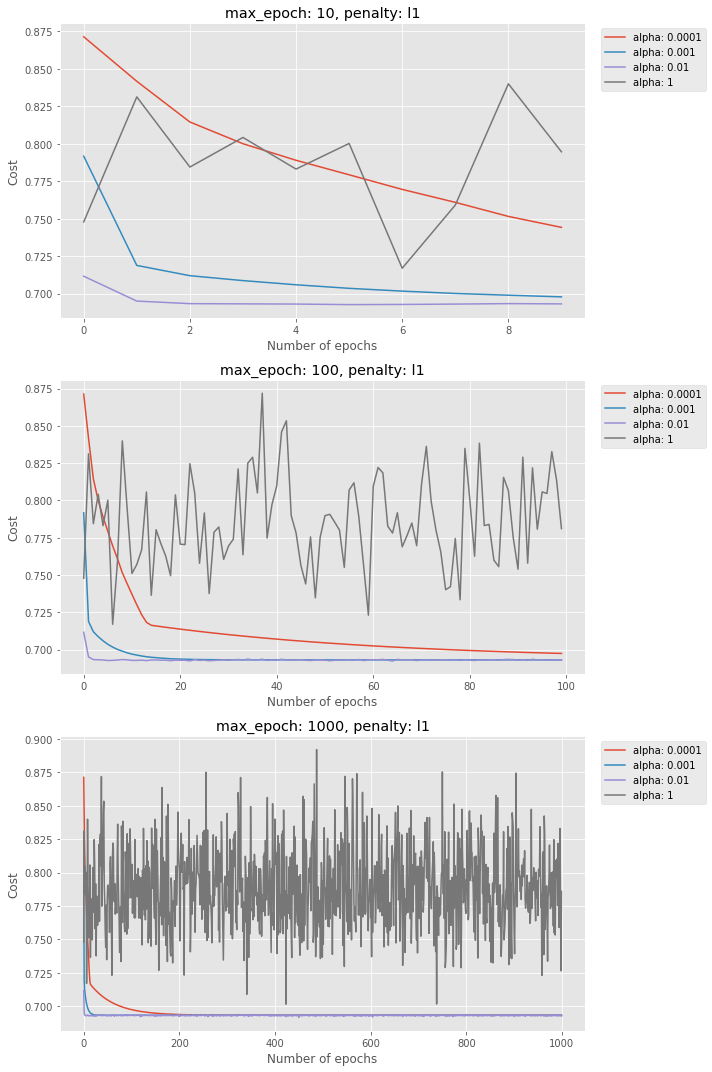

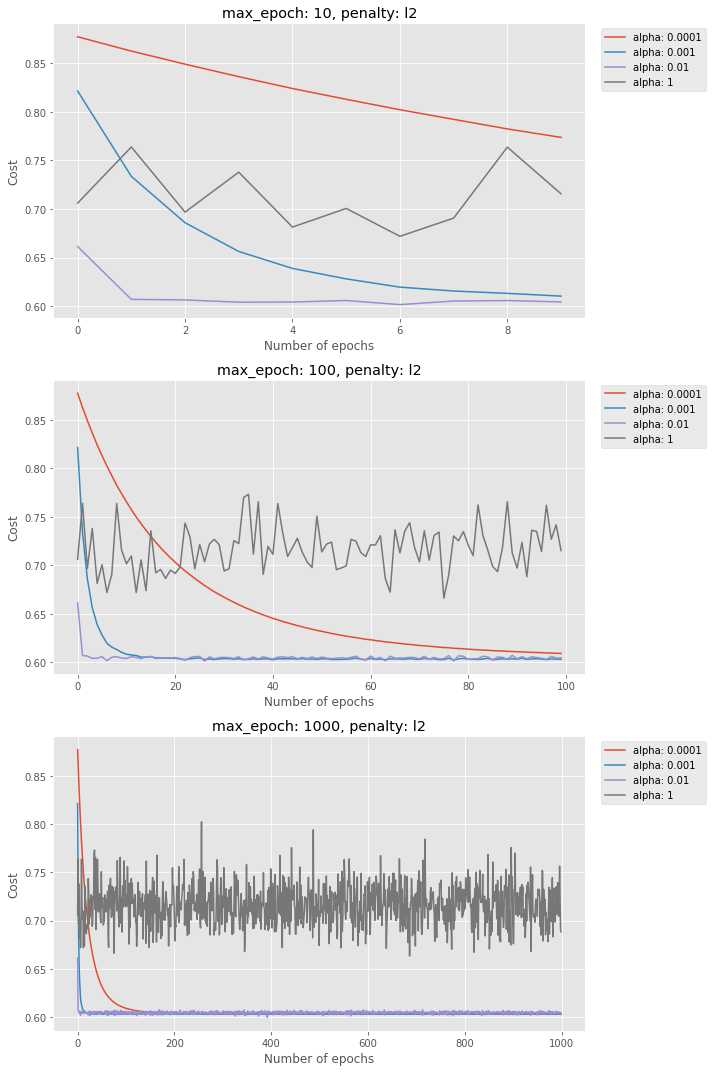

In [11]:
for penalty in ['no', 'l1', 'l2']:
    params['penalty'] = [penalty]
    param_grid = ParameterGrid(params)
    plot_cost(X_scaled, y, param_grid)

**Вывод**  
Судя по графикам, с шагом обучения alpha=0.01, и регуляризацией l1 и l2 (остальные значения по умолчанию), процесс обучения сходится уже на первых итерациях.  
При уменьшении шага (alpha=0.001, 0.0001), процесс сходится намного медленнее.  
При большом шаге (alpha=10), судя по всему, процесс не сходится.  

Для подбора корректных параметров для предсказания, необходимо использовать, например, кросс-валидацию (что не входит в задачу данного ДЗ).

## Дополнительные исследования

### Изменение значений коэффициентов в процессе обучения

Отобразим изменения значения весов при различных значениях параметра C (max_epoch=100, alpha=0.01  для регуляризаций l1 и l2)

In [12]:
def plot_coefs(X, y, param_grid):
    C_list = sorted(set([param['C'] for param in param_grid]))
    C_count = len(C_list)
    fig, axes = plt.subplots(C_count, 1, squeeze=False, figsize=(10, 15))
    
    for i, C in enumerate(C_list):
        C_grid = [param for param in param_grid if param['C'] == C]
        
        for params in C_grid:    
            model = MySGDClassifier()
            model.set_params(**params)
            model.fit(X, y)
            
            coefs = DataFrame(np.hstack(model.coefs_).T, columns=['w0', 'w1', 'w2'])

            title = 'max_epoch: {}, penalty: {}, C: {}'.format(params['max_epoch'], params['penalty'], 
                                                               params['C'])
            coefs.plot(ax=axes[i, 0])
            axes[i, 0].set_title(title)
            axes[i, 0].legend(loc='upper left', bbox_to_anchor=(1.02, 1))
            axes[i, 0].set_xlabel('Number of epochs')
            axes[i, 0].set_ylabel('Coefficent value')
            plt.tight_layout()
                        
    plt.show()

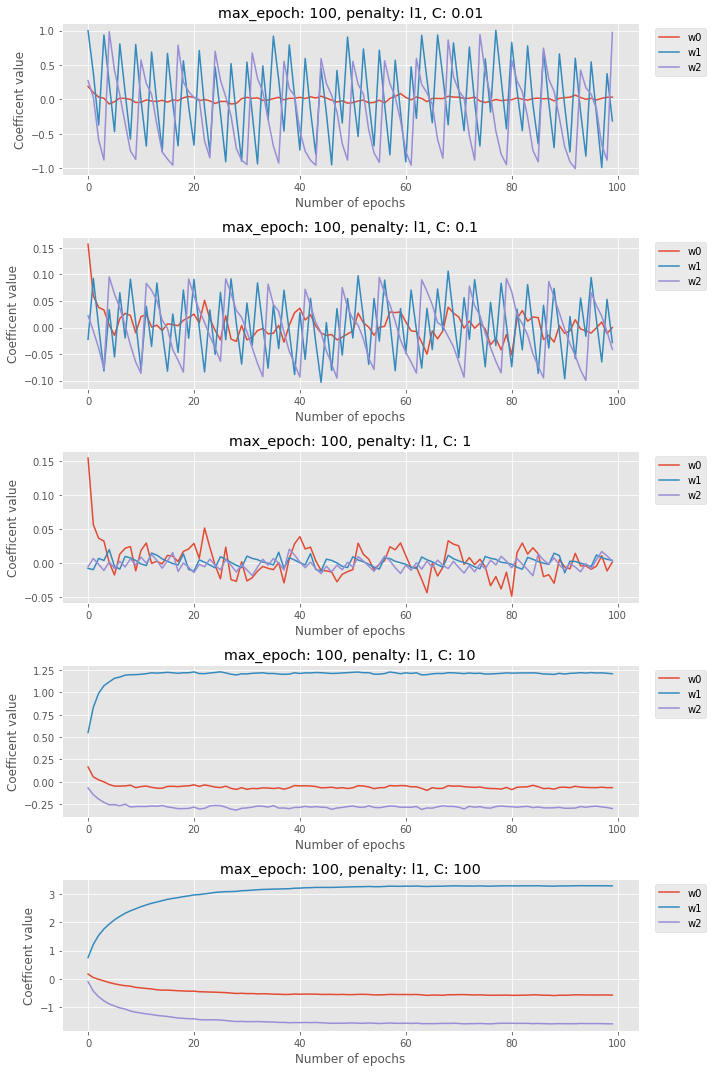

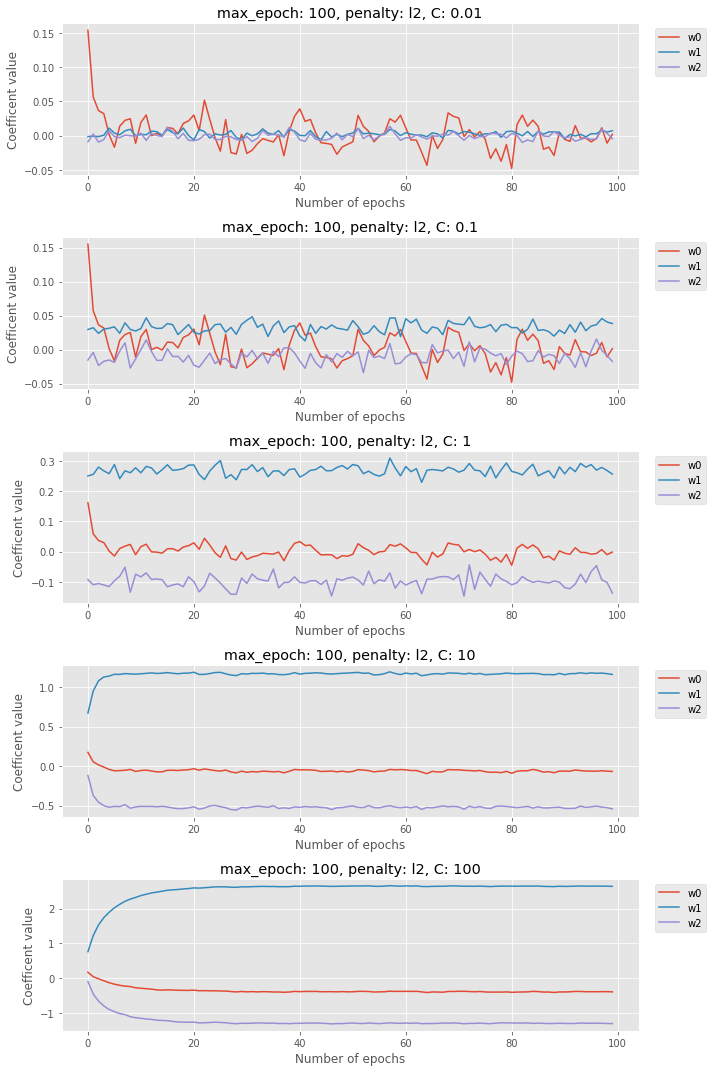

In [13]:
params = {'C': [0.01, 0.1, 1, 10, 100], 'max_epoch': [100], 'alpha': [0.01]}
for penalty in ['l1', 'l2']:
    params['penalty'] = [penalty]
    param_grid = ParameterGrid(params)
    plot_coefs(X_scaled, y, param_grid)

**Вывод**  
При увеличении регуляризации (уменьшении параметра C; C <= 1), значения весов уменьшается, осциллируют около определенных значений:  
- Для l1-регуляризации, значения весов осциллируют около нуля  
- Для l2-регуляризации, значения весов осциллируют около значений, близким к нулю, но с определенным смещением  

Данные выводы, предположительно, совпадают с характером типов регуляризаций с увеличением регуляризации l1, значения весов постепенно обнуляются; в случае l2 регуляризации, значения приближаются к нулю, но никогда его не достигают.  

Осцилляцию, а не обнуление или плавное уменьшение значения весов, скорее всего, можно объяснить тем, что применяется SGD (не Batch Gradient Descent).

Параметр C необходимо подбирать также, например, с помощью кросс-валидации (что не входит в ДЗ)

### Визуализация процесса подбора параметров

Обучим модель с alpha=0.01, max_epoch=100, penalty='l2', C=10 для визуализации процесса подбора параметров.  
Для этого для каждой эпохи рисуем полученную разделяющую границу, и создаем анимацию.

Задаем исходное состояние весов и рисуем разделяющую границу между классами c указанными весами

MySGDClassifier(C=10, alpha=0.01, max_epoch=100, penalty='l2', random_seed=42)


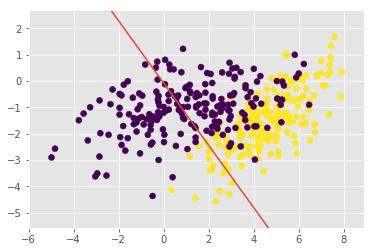

In [14]:
from matplotlib import animation
from IPython.display import HTML

model = MySGDClassifier(max_epoch=100, C=10, penalty='l2')
print(model.fit(X, y))

coefs = np.hstack(model.coefs_).T

def init_plot(coefs, X, y):
    fig, ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1], c=y)
    
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_bound = np.array([x_min, x_max])
    y_bound = -(coefs[0, 0] + coefs[0, 1] * x_bound) / coefs[0, 2]
    
    ax.set_xlim(x_min - 1, x_max + 1)
    ax.set_ylim(y_min - 1, y_max + 1)
    line = ax.plot(x_bound, y_bound)[0]
    
    return fig, line, x_bound

fig, line, x_bound = init_plot(coefs, X, y)

In [15]:
def animate(i, theta, x_bound):
    y_bound = -(theta[i, 0] + theta[i, 1] * x_bound) / theta[i, 2]
    line.set_ydata(y_bound)
    return line,
    

anim = animation.FuncAnimation(fig, animate, frames=len(coefs), repeat=False,
                               interval=200, blit=True, fargs=(coefs, x_bound))
HTML(anim.to_jshtml())